# Microsoft Detection Classification
Our goal is to fit a model that can tell us according to some features weather the device is detected or not.
This work was done it colabaration with Dror Salti



In [1]:
from scipy import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import random
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import lightgbm as lgb
import re
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

# Loading The Data
The data can be downloaded from Kaggle in the following link:

https://www.kaggle.com/c/microsoft-malware-prediction/data

Due to the large scale of the dataset (8.6 million records), we analyzed the structure of the data, applied different preprocess tools and excecuted the differents models hyper parameter tuning on a portion of the data (10%) that was randomly selected. Afterwards we redid the process with the full data before modeling.

In [2]:
path = 'C:/Users/admin/Desktop/לימוד אינטרנטי/microsoft_malware/train.csv'

#p = 0.1  # 10% of the lines
#dataset = pd.read_csv( path, header=0, skiprows=lambda i: i>0 and random.random() > p)

dataset = pd.read_csv(path)
pd.set_option("display.precision", 8)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.max_rows", 100)

C:\Users\admin\Documents\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Preprocessing the data

First of all we look on the "dry" details of each variable:
1. Missing values fraction
2. Skewness measure
3. Number of unique values of each variable



In [3]:
print((dataset.isnull().sum()/dataset.shape[0]).sort_values(ascending=False))


PuaMode                                              0.99973925
Census_ProcessorClass                                0.99589925
DefaultBrowsersIdentifier                            0.95137750
Census_IsFlightingInternal                           0.83037975
Census_InternalBatteryType                           0.71026725
Census_ThresholdOptIn                                0.63499075
Census_IsWIMBootEnabled                              0.63414000
SmartScreen                                          0.35621575
OrganizationIdentifier                               0.30839350
SMode                                                0.06025950
CityIdentifier                                       0.03654600
Wdft_IsGamer                                         0.03397350
Wdft_RegionIdentifier                                0.03397350
Census_InternalBatteryNumberOfCharges                0.03012975
Census_FirmwareManufacturerIdentifier                0.02047600
Census_IsFlightsDisabled                

As we can see, there are some featurs that is not informative: too many NULL's, too many categories, or skewness very high (actually there is one category).

## Dealing with NA Values
**We decided to remove the following features because the NA fraction was too large:**

'PuaMode' (99.97%), 'Census_ProcessorClass' (99.6%), 'Census_InternalBatteryType' (71%), 'Census_IsFlightingInternal (83%)', 'Census_ThresholdOptIn' (63.5%), 'Census_IsWIMBootEnabled' (63.4%), 'SmartScreen' (35.61%).

**For the following features we decided to remove the records with NA values because the fraction of missingness is small (0.4%) and the same records has NA in those variables:**

'AVProductStatesIdentifier', 'AVProductsInstalled', 'AVProductsEnabled', 'Census_ProcessorCoreCount'.

**For the following features we decided too fill NA with most common value. We didn't want to remove more records:**

'RtpStateBitfield', 'Firewall', 'Census_IsVirtualDevice', 'Census_IsAlwaysOnAlwaysConnectedCapable', 'Wdft_IsGamer'.

**For the numerical variables with NA values we decided to fill these value with the median. The features are:**

'Census_PrimaryDiskTotalCapacity', 'Census_SystemVolumeTotalCapacity','Census_TotalPhysicalRAM', 'Census_InternalPrimaryDiagonalDisplaySizeInInches', 'Census_InternalPrimaryDisplayResolutionHorizontal', 'Census_InternalPrimaryDisplayResolutionVertical', 'Census_InternalBatteryNumberOfCharges'.

**One feature with many NA values is the deafultBrowser. We decided to treat this feature as a binary variable- 1 if there is a deafult browser and 0 other wise**

Later, we explain how we chose to deal with the other variables with NA values.




In [4]:
tooManyNULLVars = ['PuaMode', 'Census_ProcessorClass', 'Census_InternalBatteryType', 'Census_IsFlightingInternal',
                   'Census_ThresholdOptIn', 'Census_IsWIMBootEnabled'] #more than 50% missing values
#remove rows with NA
#vars = ['AVProductStatesIdentifier', 'AVProductsInstalled', 'AVProductsEnabled', 'Census_ProcessorCoreCount']
#for cat in vars:
    #dataset = dataset[~np.isnan(dataset[cat])]

#fill most common value in NA
vars = ['RtpStateBitfield', 'Firewall', 'Census_IsVirtualDevice', 'Census_IsAlwaysOnAlwaysConnectedCapable', 
        'Wdft_IsGamer','AVProductsInstalled','AVProductsEnabled','IsProtected']
for cat in vars:
    dataset[cat] = dataset[cat].fillna(dataset[cat].value_counts().index[0])

#fill with unique value
vars = ['SmartScreen']
dataset[vars] = dataset[vars].fillna("empty")

#fill median value in NA
vars = ['Census_PrimaryDiskTotalCapacity', 'Census_SystemVolumeTotalCapacity','Census_TotalPhysicalRAM',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches', 'Census_InternalPrimaryDisplayResolutionHorizontal',
        'Census_InternalPrimaryDisplayResolutionVertical', 'Census_InternalBatteryNumberOfCharges','Census_ProcessorCoreCount']
for cat in vars:
    dataset[cat] = dataset[cat].fillna(dataset[cat].median())

#null or not null
vars = ['DefaultBrowsersIdentifier']
for cat in vars:
    dataset['DefaultBrowsersIdentifier'] = dataset['DefaultBrowsersIdentifier'].isnull().astype('int')


## Special Features
1. We noticed that in 'ProductName' feature, 98.5% are 'win8defender', 1.49% are 'mse' and 0.1% are niether both. So we change them to 'win8defender'.
2. We noticed that in 'Census_PrimaryDiskTypeName' feature, there are 2 major categories: 'HDD' and 'SSD' and the rest of the categories are very small. So we united them to one category, named 'other'.
3. We noticed that in 'Processor' and 'Census_OSArchitecture' features there are some categories that contains 64 so we united them to one category- '64'. 


In [5]:
#column 1 - productName
#98.5% one major category, 1.45% minor category, 8 other so we change them to the main category
dataset['ProductName'] = dataset['ProductName'].apply(lambda x: x if x in ['mse'] else 'win8defender')

##column 43 - Census_PrimaryDiskTypeName
#2 major categories, the rest of the rows change to other categories
dataset['Census_PrimaryDiskTypeName'] = dataset['Census_PrimaryDiskTypeName'].apply(lambda x: x if x in ['HDD','SSD'] else 'other')

#columns 19,55 - Processor, Census_OSArchitecture
vars = ['Processor', 'Census_OSArchitecture']
for var in vars:
    dataset[var] = dataset[var].apply(lambda x: '64' if x in ['amd64', 'arm64', 'x64'] else '86')


## Categorial variables
There are many features that are categorial. Some of them with very small categories, so we decided to unite these categories into one -'other', and to add to this category the NA values. 

In [6]:
#categorical variables
categorial = ['ProductName','AVProductStatesIdentifier', 'CountryIdentifier', 'LocaleEnglishNameIdentifier', 'OsPlatformSubRelease',
              'OsSuite', 'SkuEdition', 'IeVerIdentifier', 'Census_MDC2FormFactor', 'Census_OEMNameIdentifier',
              'Census_ProcessorManufacturerIdentifier', 'Census_PrimaryDiskTypeName', 'Census_ChassisTypeName', 'Census_PowerPlatformRoleName',
              'Census_OSBranch', 'Census_OSBuildNumber', 'Census_OSEdition', 'Census_OSInstallTypeName', 'Census_OSInstallLanguageIdentifier',
              'Census_OSUILocaleIdentifier', 'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName', 'Census_ActivationChannel',
              'Census_FlightRing', 'Census_FirmwareManufacturerIdentifier', 'Wdft_RegionIdentifier', 'Processor', 'Census_OSArchitecture','SmartScreen']
for cat in categorial:
    dataset[cat] = dataset[cat].fillna(-1)
    valCounts = dataset[cat].value_counts()
    dataset[cat] = dataset[cat].apply(lambda x: x if valCounts[x] > 0.005 * len(dataset) else -1)
    dataset[cat] = dataset[cat].astype("category")
    

## Versions Features
We have in our data 3 versions features: 'EngineVersion', 'AppVersion', 'AvSigVersion'. We decided to rank them from old to new.


In [11]:
def removeDots(string):
    ans = []
    temp = ""
    for s in string:
        if(s == '.'):
            ans.append(str(temp))
            temp=''
        else:
            temp = temp+ str(s)
    ans.append(str(temp))
    ans.append(string)
    return ans

def sortVersions(data):
    values = list(data.unique())
    df = pd.DataFrame(columns=["A", "B", "C", "D", "string"])
    for i in range(len(values)):
        x = removeDots(str(values[i]))
        df.loc[i] = x
    df = df.sort_values(by=['A', 'B', 'C', 'D'])
    return list(df['string'])
    
#ordinal version variables
versions = ['AvSigVersion','EngineVersion', 'AppVersion']
for cat in versions:
    orders = sortVersions(dataset[cat])
    dataset[cat] = dataset[cat].apply(lambda x: orders.index(x))


## Skewed Features


In [12]:
pd.options.display.float_format = '{:,.4f}'.format
sk_df = pd.DataFrame([{'column': c, 'uniq': dataset[c].nunique(), 'skewness': dataset[c].value_counts(normalize=True).values[0] * 100, 'type': dataset[c].dtype}
                      for c in dataset.columns])
sk_df = sk_df.sort_values('skewness', ascending=False)
print(sk_df)

                                               column     uniq  skewness      type
75                            Census_IsWIMBootEnabled        1  100.0000   float64
28                                            PuaMode        1  100.0000    object
5                                              IsBeta        2   99.9992     int64
69                           Census_IsFlightsDisabled        2   99.9991   float64
68                         Census_IsFlightingInternal        2   99.9981   float64
27                                    AutoSampleOptIn        2   99.9973     int64
71                              Census_ThresholdOptIn        2   99.9736   float64
29                                              SMode        2   99.9550   float64
65                   Census_IsPortableOperatingSystem        2   99.9437     int64
35                                Census_DeviceFamily        3   99.8383    object
83                                   OrganizationSize        3   99.7500  category
33  

The following features has high skewnees:
'IsBeta', 'AutoSampleOptIn', 'SMode', 'Census_DeviceFamily', 'Census_IsPortableOperatingSystem', 'Census_IsFlightsDisabled'.

Actually more then 99.9% of the data are in the same category in those features. Therefore we decided to remove them (in order to avoid over-fitting).

In [13]:
oneCategoryVars = ['IsBeta', 'AutoSampleOptIn', 'SMode', 'Census_DeviceFamily',
                   'Census_IsPortableOperatingSystem', 'Census_IsFlightsDisabled','UacLuaenable'] #only one category in the data (or 99% of it)

## More uninformative features
We found out that are some features that are contained in others. Moreover we noticed that there are some categorial features with too many categories. This situation can lead to an over fitting problem and to increase the runtime of the process (creating many dummies variables).

So we decided to remove them.

In [14]:
unInformativeVars= ['CityIdentifier', 'GeoNameIdentifier', 'Census_OEMModelIdentifier',
                    'Census_ProcessorModelIdentifier', 'Census_OSBuildRevision', 'Census_FirmwareVersionIdentifier'] # too many categories
containedVars = ['OsVer', 'Platform', 'OsBuildLab', 'Census_OSVersion', 'Census_OSSkuName'] #data that can be inferred from other variables

In [15]:
delVars = tooManyNULLVars + unInformativeVars + containedVars + oneCategoryVars
dataset.drop(delVars, axis=1, inplace=True)

We created a new feature 'Organization Size'. This feature describe the size of the organization that the device belongs to. We decided to divide the organizations into three categories:
1. Big - more than 10000 devices
2. Medium - between 100-10000 devices.
3. Small - less than 100 devices.

In addition we noticed that 'OrganizationIdentifier' contains 2 major categories "27" and "18"  and many more categories that are much smaller. So we united them into one category.


In [16]:
#-----creating new features----
x = dataset['OrganizationIdentifier'].value_counts()
new = x[dataset['OrganizationIdentifier']]
new[np.isnan(new)] = 0
new = np.asarray(new)
dataset['OrganizationSize'] = new
dataset['OrganizationSize'] = pd.cut(dataset['OrganizationSize'].rank(method='first'),
                                     bins=[0,100,10000,10000000], labels=['small', 'medium', 'big'])
dataset['OrganizationSize'] = dataset['OrganizationSize'].astype('category')
dataset['OrganizationIdentifier'] = dataset['OrganizationIdentifier'].apply(lambda x: x if x in [18,27] else 0)
dataset['OrganizationIdentifier'] = dataset['OrganizationIdentifier'].astype('category')

## Correlation Matrix
We would like to plot the correlation matrix of the numerical variables of the data in order to diagnose high correlated variables.

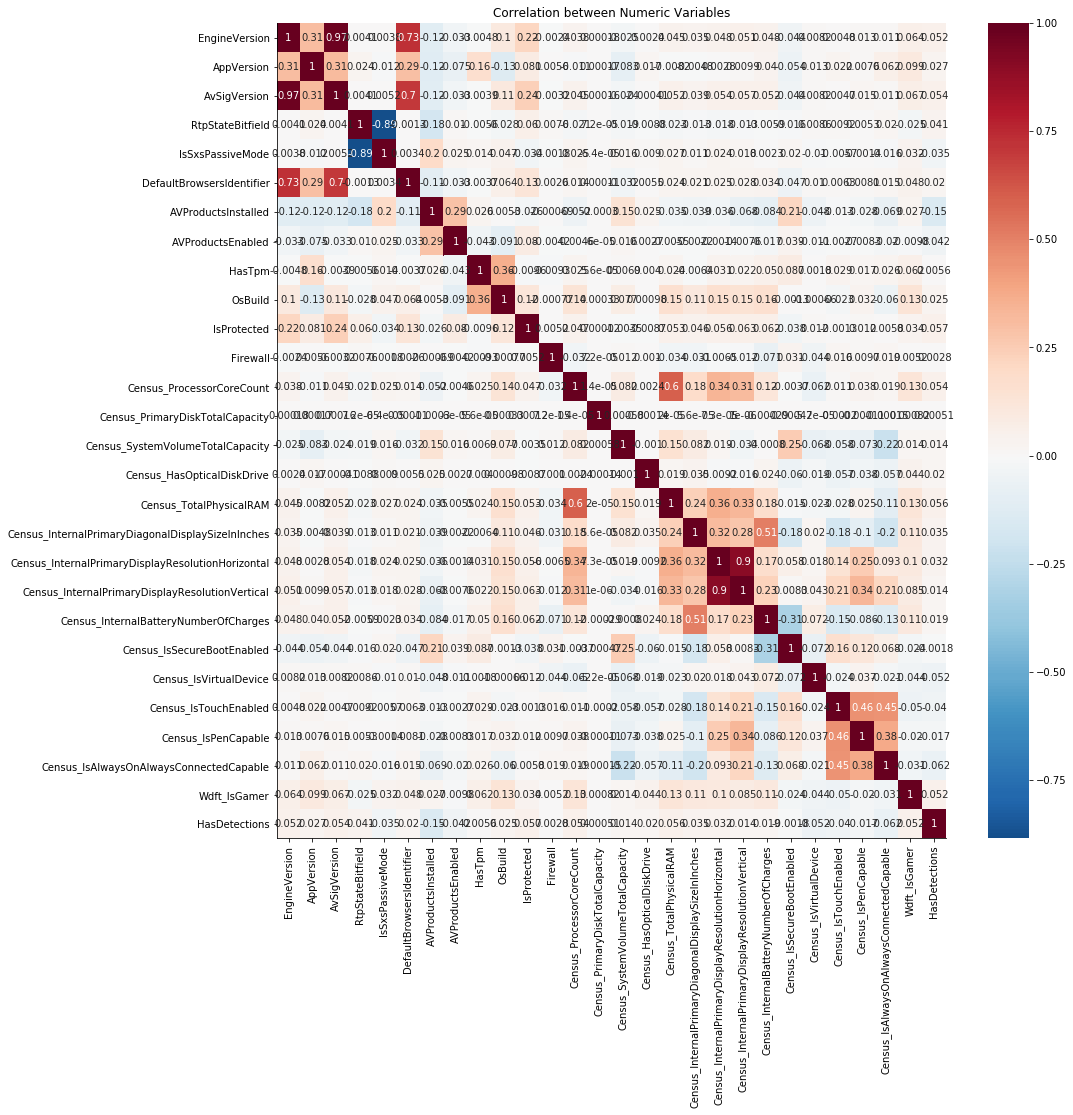

In [17]:
#----Plots----
# calculate the correlation matrix
corr = dataset.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, cmap='RdBu_r', annot=True, center=0.0)
plt.title('Correlation between Numeric Variables')
sns.despine()

As we can see there are 3 pairs of variables that are highly correlated (absolute value greater than 0.85). So we decided to remove one of them that has lower correlation with the target value. We chose not to remove Engine_Version because it has a relatively high correlation with the target variable.

So we remove 'IsSxsPassiveMode', 'Census_InternalPrimaryDisplayResolutionVertical' 

In [18]:
highCorrVars = ['IsSxsPassiveMode', 'Census_InternalPrimaryDisplayResolutionVertical']
dataset.drop(highCorrVars, axis=1, inplace=True)

### Prepearing the Data for the algorithms

In [19]:
y = dataset['HasDetections']
MachineIdentifier = dataset['MachineIdentifier']
dataset.drop(['MachineIdentifier','HasDetections'], axis=1, inplace=True)

Categories = categorial + ['OrganizationIdentifier', 'OrganizationSize']
train = pd.get_dummies(dataset, columns=Categories)
train = train.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', 'Dot', x))
#spliting the data to train and validation sets
x_train, x_test, y_train, y_test = train_test_split(train, y, test_size=0.20, random_state=42)
del train, dataset
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.25, random_state=42)


# Machine Learning Models

We are fitting some ML models to the data: Random Forest, XGBoost, SVM, KNN.



In [ ]:
from collections import Counter
z = list(x_train.columns[192:])
print(Counter(z))


## Random Forest
The first model that we tried to fit is random forest.

In the first stage we are tunning the hyperparameters of the models. We chose to tune the following parameters wuth grid search:
1. Number of trees.
2. Max depth of each tree.
3. The criterion of building the tree.

In [ ]:
#hyperparameters for random forest - grid search
params_grid = [{'criterion': ['gini', 'entropy'], 'max_depth': [10, 25, 50], 'n_estimators': [50, 100, 300]}]
rf_model = GridSearchCV(RandomForestClassifier(), params_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=3)
rf_model.fit(x_train, y_train)

print('\n Best hyperparameters:')
print(rf_model.best_params_)


The parameters that we got are:
1. Number of trees - 100
2. Max depth - 25
3. Criterion - entropy

Now we train the model again (this time on all the train set) and see the accuracy rate:

In [22]:
RF_MODEL = RandomForestClassifier(criterion='entropy', max_depth=25, n_estimators=100, verbose=1, n_jobs=-1)
RF_MODEL.fit(x_train, np.ravel(y_train))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.5min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    7.5s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   23.6s finished


Accuarcy on train set is: 0.7412883333333333


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    2.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    7.6s finished


Accuarcy on validation set is: 0.65305125


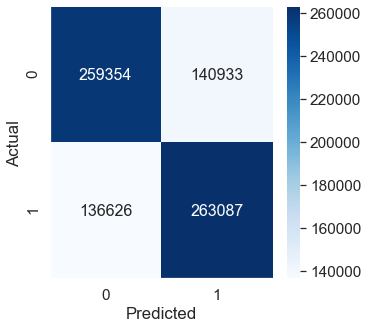

In [23]:
y_predTrain = RF_MODEL.predict(x_train)
accTrain = accuracy_score(y_train, y_predTrain)
print("Accuarcy on train set is: " + str(accTrain))

y_pred_RF = RF_MODEL.predict(x_cv)
acc = accuracy_score(y_cv, y_pred_RF)
print("Accuarcy on validation set is: " + str(acc))

confusion = confusion_matrix(y_cv, y_pred_RF)
df_cm = pd.DataFrame(confusion, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,5))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')# font size
sns.despine()

The Random-Forest model achived accuracy on the validation set.

## XGBoost

In the first stage we are tunning the hyperparameters of the models. We chose to tune the following parameters wuth grid search:

1. max_depth
2. subsample
3. gamma
4. colsample_bytree


In [ ]:
params = {"max_depth"        : [ 15, 25, 35],
 "subsample" : [ 0.7, 0.8, 0.9, 1],
 "gamma"            : [ 0.1, , 1, 5 ],
 "colsample_bytree" : [ 0.3,  0.5 , 0.8 ] }

xgb = XGBClassifier(learning_rate=0.02, n_estimators=100, objective='binary:logistic')

xgb_model = GridSearchCV(xgb, params_grid, cv=5, n_jobs=-1,verbose=2, scoring='accuracy')
xgb_model.fit(x_train, y_train)

print('\n Best hyperparameters:')
print(xgb_model.best_params_)

The parameters that we chose according to the grid search are:
1. colsample_bytree = 0.4.
2. subsample = 0.8.
3. max depth = 15.
4. gamma = 1.

Now we train the model again (this time on all the train set) and see the accuracy rate:


In [20]:
xgb_model = xgb.XGBClassifier(scale_pos_weight=1, learning_rate=0.02, verbosity=1, 
                      colsample_bytree = 0.8, subsample = 0.8, objective='binary:logistic',
                      n_estimators=100, reg_alpha = 0.3, max_depth=15, gamma=1, n_jobs=-1)
xgb_model.fit(x_train, np.ravel(y_train))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0.3,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=1)

Accuarcy on train set is: 0.6800975
Accuarcy is: 0.65484


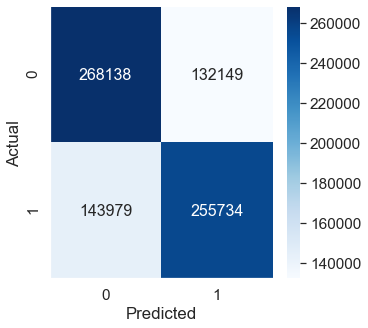

In [21]:
y_predTrain = xgb_model.predict(x_train)
accTrain = accuracy_score(y_train, y_predTrain)
print("Accuarcy on train set is: " + str(accTrain))

y_pred_xgb = xgb_model.predict(x_cv)
acc = accuracy_score(y_cv, y_pred_xgb)
print("Accuarcy is: " + str(acc))

confusion = confusion_matrix(y_cv, y_pred_xgb)
df_cm = pd.DataFrame(confusion, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,5))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')# font size
sns.despine()

The XGBoost model achived accuracy on the validation set.

## LGBM

We chose to tune the following hyperparameters:
1. boosting type.
2. num of leaves.
3. max depth.
4. number of tree.

We chose relatively large values for max depth and number of leaves due to the high dimensionality of the data-set.

In [ ]:
lgbm = lgb.LGBMClassifier()
boosting_type = ['gbdt', 'dart']
num_leaves = [100,300,500,1000, 2000] #list(range(30, 150)),
max_depth = list(range(7,25,3))
n_estimators = [100, 250, 500, 1000, 2000]
lgbm_grid = dict(boosting_type=boosting_type, num_leaves=num_leaves,
                 max_depth = max_depth, n_estimators=n_estimators)


grid_search = GridSearchCV(estimator=lgbm, param_grid=lgbm_grid,
              n_jobs=-1, scoring='accuracy', error_score=0, verbose=2, cv=3)

print('\n Best hyperparameters:')
print(lgbm.best_params_)

The parameters that we got are:
1. boosting type: 'gbdt'
2. num of leaves: 1024
3. max depth: 13
4. number of tree: 1000

The values for the following hyperparameters we took from the XGboost model in order to reduce the computation time: subsample, colsample_bytree, reg_alpha.

Now we train the model again (this time on all the train set) and see the accuracy rate:

In [24]:
lgb_model = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=800, max_depth=13,
                                verbosity=1, learning_rate=0.02, n_estimators=1000,
                                subsample=0.8, colsample_bytree=0.8, reg_alpha=0.3)
lgb_model.fit(x_train, np.ravel(y_train))

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
               importance_type='split', learning_rate=0.02, max_depth=13,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=800, objective=None,
               random_state=None, reg_alpha=0.3, reg_lambda=0.0, silent=True,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0,
               verbosity=1)

Accuarcy on train set is: 0.6958525
Accuarcy is: 0.66451125


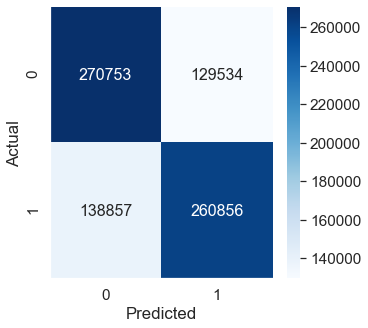

In [25]:
y_predTrain = lgb_model.predict(x_train)
accTrain = accuracy_score(y_train, y_predTrain)
print("Accuarcy on train set is: " + str(accTrain))

y_pred_lgbm = lgb_model.predict(x_cv)
acc = accuracy_score(y_cv, y_pred_lgbm)
print("Accuarcy is: " + str(acc))

confusion = confusion_matrix(y_cv, y_pred_lgbm)
df_cm = pd.DataFrame(confusion, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,5))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')# font size
sns.despine()

The LGBM model achived accuracy on the validation set.

## Logistic Regression

We tried to fit the data to a logistic regression model, in order to get more information about the relevant features to the target value


In [28]:
import statsmodels.api as sm

In [ ]:
LR_model = sm.Logit(y_train, x_train)
LR_res = LR_model.fit()
print(LR_res.summary())

As we can see the $R^2$ measure is very low (0.04), which means that this model is not fit to this data and therefore we won't use it.

# Ensembling Models

For the second stage of building our classifier, we decided to ensemble the 3 models: Random-Forest, XGBoost and LightGBM, in order to reduce the over-fitting and achive high accuracy.

We tried 2 different ensembling methods:
1. Logistic regression model
2. KNN





First, we plot the corrlation matrix between the predictions of the 3 pre-trained models:

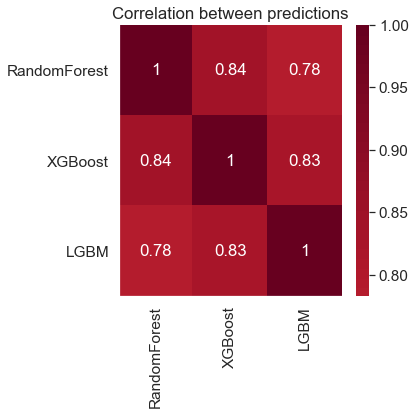

In [26]:
preds = pd.DataFrame(
    {'RandomForest': y_pred_RF,
     'XGBoost': y_pred_xgb,
     'LGBM': y_pred_lgbm
    })
corrPreds = preds.corr()
plt.figure(figsize=(5,5))
sns.heatmap(corrPreds, cmap='RdBu_r', annot=True, center=0.0)
plt.title('Correlation between predictions')
sns.despine()

## Logistic Regression

In [30]:
LR_model = sm.Logit(np.ravel(y_cv),sm.add_constant(preds))
LR_res = LR_model.fit()
print(LR_res.summary())

finalpreds = LR_res.predict(sm.add_constant(preds))
finalpreds = finalpreds.apply(lambda x: 1 if x > 0.5 else 0)
print("The Accuracy is: " + str(accuracy_score(finalpreds, y_cv)))


Optimization terminated successfully.
         Current function value: 0.634209
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               800000
Model:                          Logit   Df Residuals:                   799996
Method:                           MLE   Df Model:                            3
Date:                Mon, 13 Jul 2020   Pseudo R-squ.:                 0.08503
Time:                        22:28:20   Log-Likelihood:            -5.0737e+05
converged:                       True   LL-Null:                   -5.5452e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.7433      0.003   -214.396      0.000      -0.750      -0.737
RandomForest     0.4003

In [43]:
# The resulting model provides the exact same prediction the lgbm model alone

## KNN

In [34]:
#knn
k_range = [4,6,8,10,15]
score_list =[]
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(preds, np.ravel(y_cv))
    y_pred = knn.predict(preds)
    acc = accuracy_score(y_cv, y_pred)
    score_list.append(acc)
    print("The Score for k=" +str(k) + " is: " + str(acc))
plt.plot(k_range, score_list)
plt.show()
sns.despine()

The Score for k=4 is: 0.50074875


KeyboardInterrupt: 

The KNN fitting is very bad and achives poor results.

## Final model

Accuarcy on train set is: 0.6892153125
Accuarcy is: 0.66544875


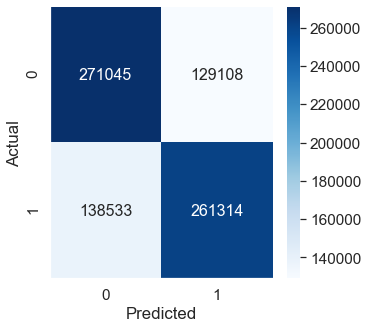

In [35]:
# As the lgbm achieves the best results, we shall use it alone after trained on the entire train and cv dataets

x_full = pd.concat([x_train,x_cv])
y_full = pd.concat([y_train,y_cv])


lgb_model = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=800, max_depth=13,
                                verbosity=1, learning_rate=0.02, n_estimators=1000,
                                subsample=0.8, colsample_bytree=0.8, reg_alpha=0.3)
lgb_model.fit(x_full, np.ravel(y_full))

y_predTrain = lgb_model.predict(x_full)
accTrain = accuracy_score(y_full, y_predTrain)
print("Accuarcy on train set is: " + str(accTrain))

y_pred_lgbm = lgb_model.predict(x_test)
acc = accuracy_score(y_test, y_pred_lgbm)
print("Accuarcy is: " + str(acc))

confusion = confusion_matrix(y_test, y_pred_lgbm)
df_cm = pd.DataFrame(confusion, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (5,5))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')# font size
sns.despine()